In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


## Feature Engineering with Linear Regression: Applied to the Ames Housing Data

Using the Ames Housing Data:

Dean De Cock
Truman State University
Journal of Statistics Education Volume 19, Number 3(2011), www.amstat.org/publications/jse/v19n3/decock.pdf

In this notebook, we will build some linear regression models to predict housing prices from this data. In particular, we will set out to improve on a baseline set of features via **feature engineering**: deriving new features from our existing data. Feature engineering is done extensively in machine learning applications, and it often makes the difference between a weak or decent model and a strong one. Sometimes feature engineering is even more important than model selection and hyperparameter tuning when it comes to improving predictions!      

We will split our data into training and validation sets, build models on various feature sets and compare their results on the validation set. We will use visual exploration, domain understanding, and intuition to construct new features that add significant predictive signal, which will be apparent in validation *r-squared* scores.

**Notebook Contents**

> 1. Simple EDA and baseline model
> 2. Basic feature engineering: adding polynomial terms
> 3. Basic feature engineering: adding interaction terms
> 4. Intermediate feature engineering: categories and features derived from category aggregates 

## 1. Simple EDA and Baseline Model

#### Load the Data, Examine and Explore

In [3]:
## Load in the Ames Housing Data
datafile = "data/Ames_Housing_Data.tsv"
df=pd.read_csv(datafile, sep='\t')

In [4]:
## Examine the columns, look at missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [5]:
# This is recommended by the data set author to remove a few outliers

df = df.loc[df['Gr Liv Area'] <= 4000,:]
df.shape

(2925, 82)

There are a *lot* of variables, many of which have a lot of missing values.  Let's pick out just a few columns and start building models using that.

In [6]:
smaller_df= df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars','SalePrice']]

In [7]:
smaller_df.describe()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,SalePrice
count,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2924.000000,2925.000000
mean,10103.583590,6.088205,5.563761,1971.302906,1984.234188,1493.978803,1.564786,2.853675,0.596923,1.765048,180411.574701
std,7781.999124,1.402953,1.112262,30.242474,20.861774,486.273646,0.551386,0.827737,0.645349,0.759834,78554.857286
min,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.000000,0.000000,0.000000,0.000000,12789.000000
25%,7438.000000,5.000000,5.000000,1954.000000,1965.000000,1126.000000,1.000000,2.000000,0.000000,1.000000,129500.000000
50%,9428.000000,6.000000,5.000000,1973.000000,1993.000000,1441.000000,2.000000,3.000000,1.000000,2.000000,160000.000000
75%,11515.000000,7.000000,6.000000,2001.000000,2004.000000,1740.000000,2.000000,3.000000,1.000000,2.000000,213500.000000
max,215245.000000,10.000000,9.000000,2010.000000,2010.000000,3820.000000,4.000000,8.000000,4.000000,5.000000,625000.000000


In [8]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2924 non-null float64
SalePrice         2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


In [9]:
# There appears to be one NA in Garage Cars - fill with 0
smaller_df = smaller_df.fillna(0)

In [10]:
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2925 non-null float64
SalePrice         2925 non-null int64
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


Now that we have a nice, filtered dataset, let's generate visuals to better understand the target and feature-target relationships: pairplot is great for this!

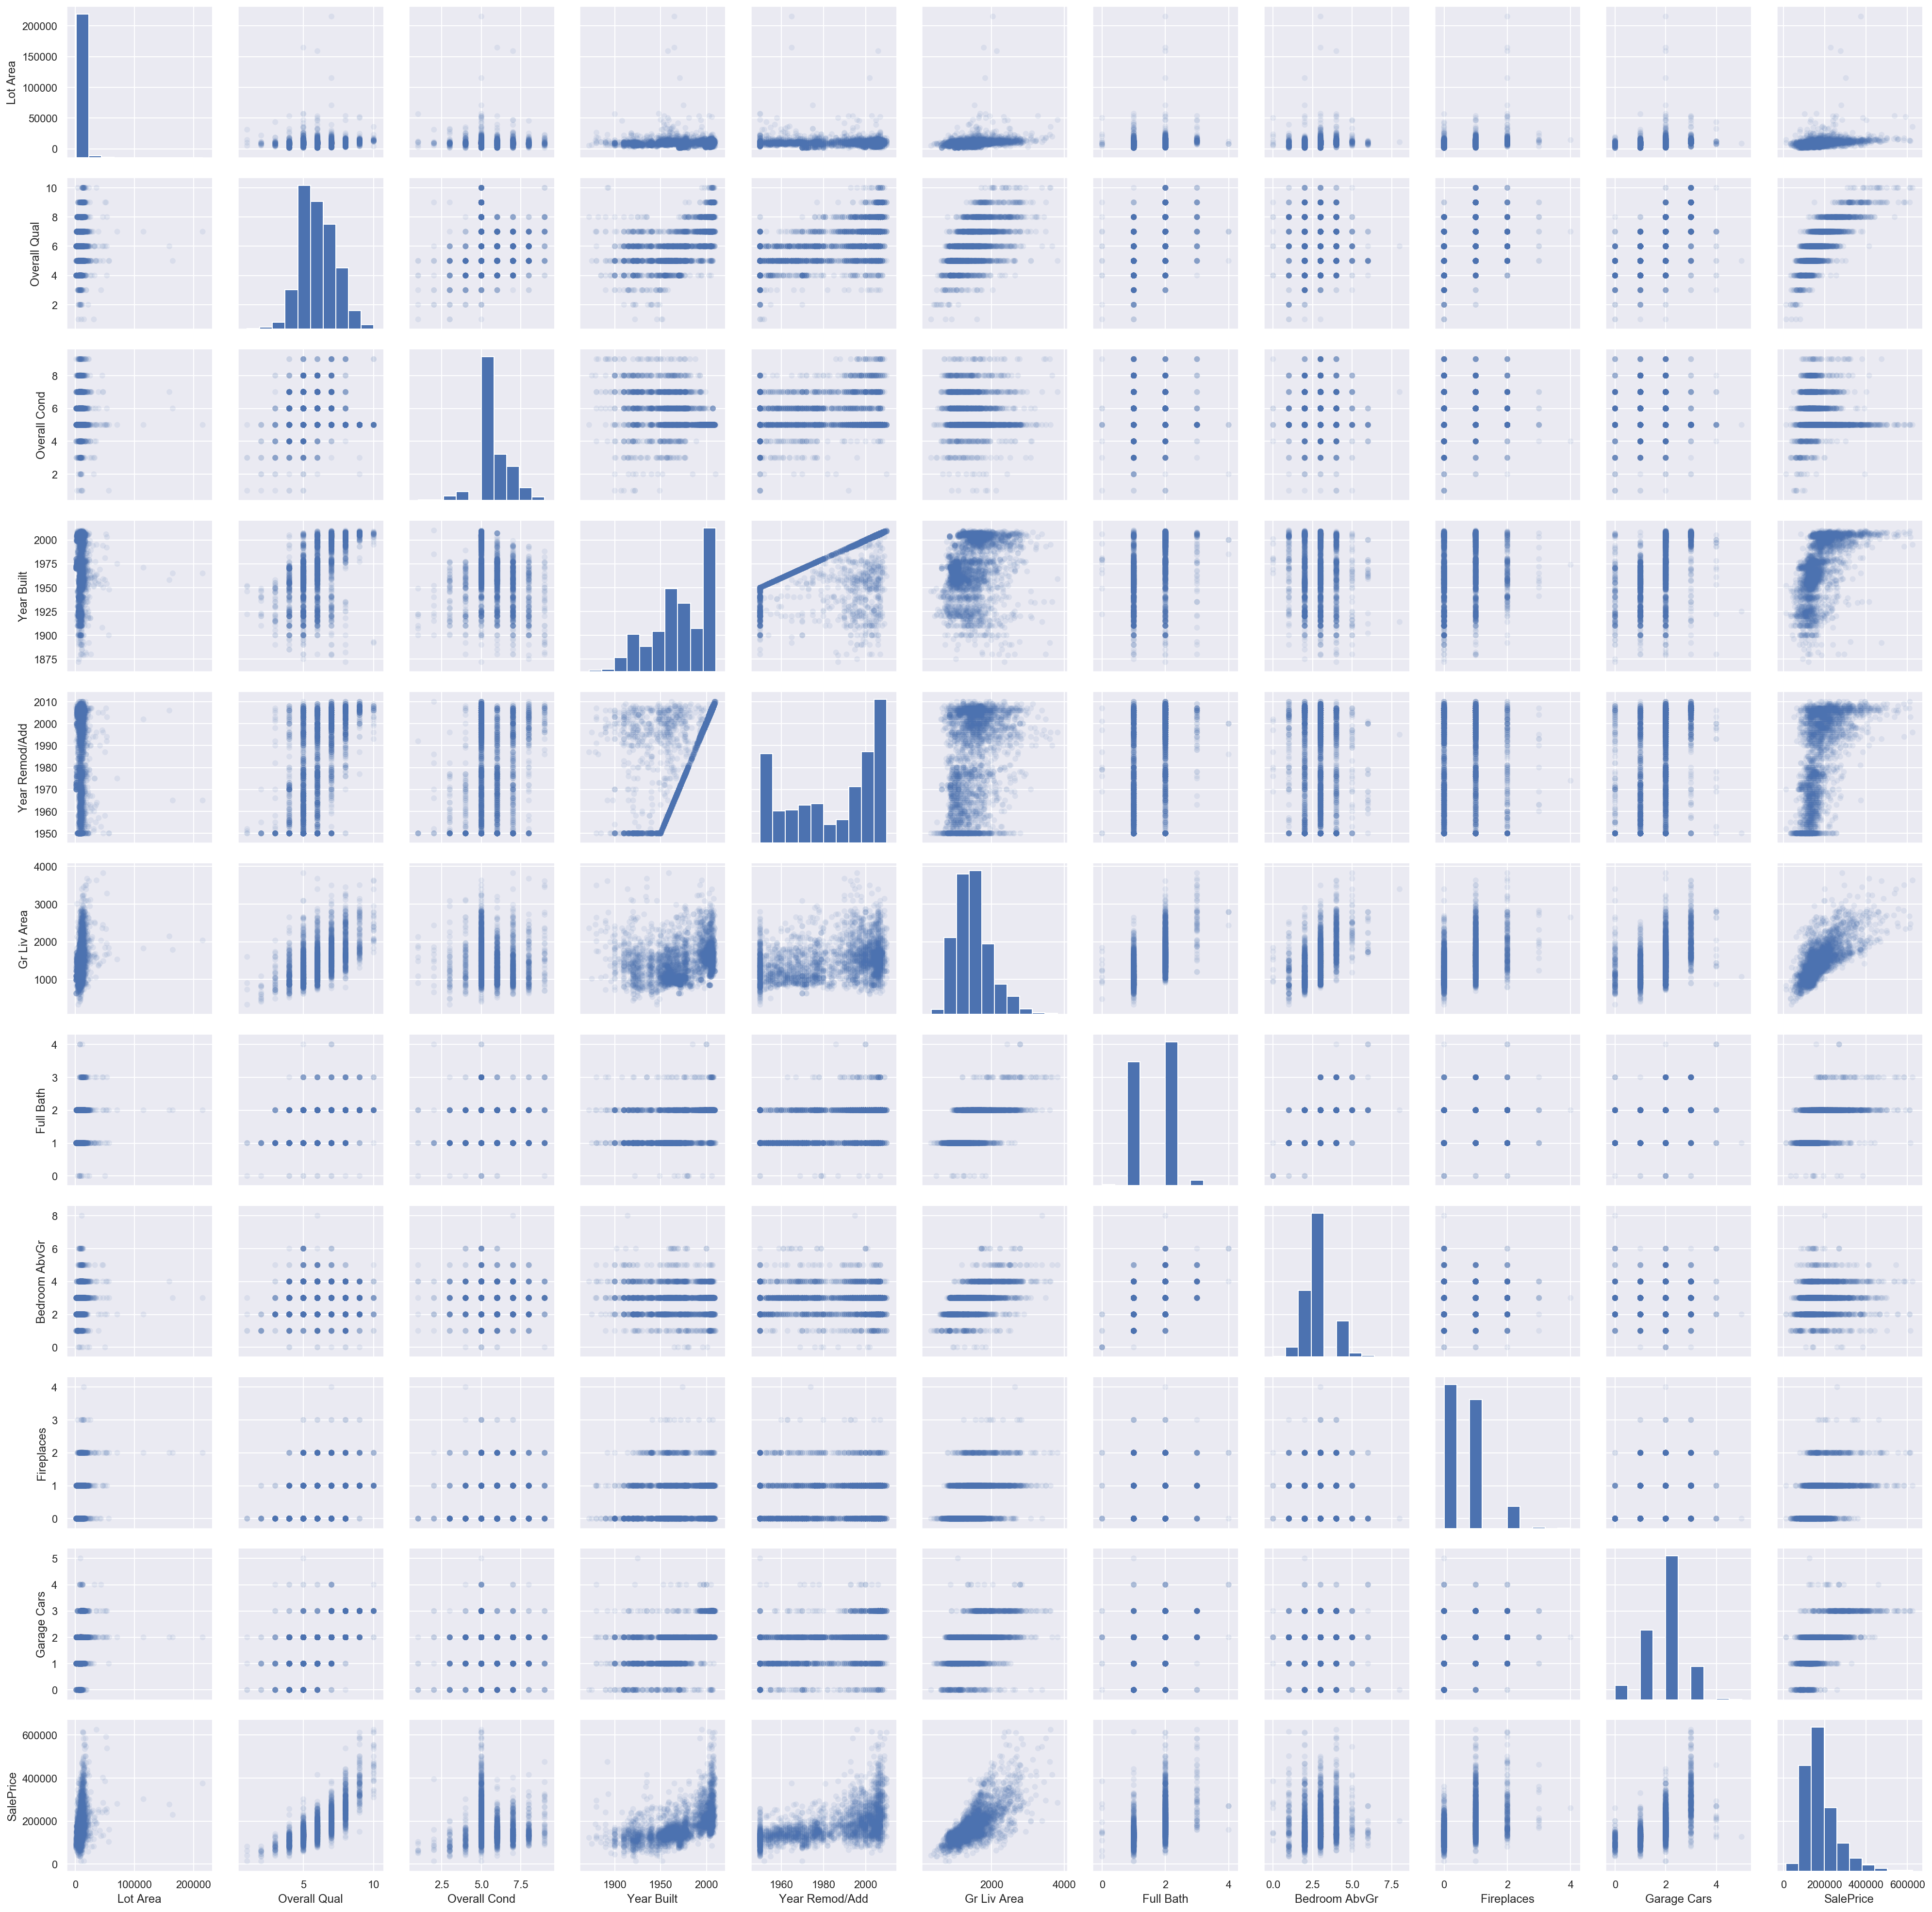

In [11]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

---
**Data Exploration Exercises**: 

1. What do these plots tell us about the distribution of the target?   

2. What do these plots tell us about the relationship between the features and the target? Do you think that linear regression is well-suited to this problem? Do any feature transformations come to mind?

3. What do these plots tell us about the relationship between various pairs of features? Do you think there may be any problems here? 

---

#### Setting up for modeling and building a baseline:

In [12]:
#Separate our features from our target

X = smaller_df.loc[:,['Lot Area', 'Overall Qual', 'Overall Cond', 
                      'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
                      'Full Bath', 'Bedroom AbvGr', 'Fireplaces', 
                      'Garage Cars']]

y = smaller_df['SalePrice']

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 10 columns):
Lot Area          2925 non-null int64
Overall Qual      2925 non-null int64
Overall Cond      2925 non-null int64
Year Built        2925 non-null int64
Year Remod/Add    2925 non-null int64
Gr Liv Area       2925 non-null int64
Full Bath         2925 non-null int64
Bedroom AbvGr     2925 non-null int64
Fireplaces        2925 non-null int64
Garage Cars       2925 non-null float64
dtypes: float64(1), int64(9)
memory usage: 331.4 KB


Now that we have feature/target data X, y ready to go, we're nearly ready to fit and evaluate a baseline model using our current feature set. We'll need to create a **train/validation split** before we fit and score the model. 

Since we'll be repeatedly splitting X, y into the same train/val partitions and fitting/scoring new models as we update our feature set, we'll define a reusable function that completes all these steps, making our code/process more efficient going forward. 

In [14]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

Great, let's go ahead and run this function on our baseline feature set and take some time to analyze the results.

In [15]:
split_and_validate(X, y)


Validation R^2 score was: 0.8183104025012532
Feature coefficient results: 

Lot Area : 1.18
Overall Qual : 19750.20
Overall Cond : 4956.09
Year Built : 534.64
Year Remod/Add : 141.23
Gr Liv Area : 73.67
Full Bath : -8692.91
Bedroom AbvGr : -10641.08
Fireplaces : 5325.00
Garage Cars : 10120.80


-----
**Review Exercise**: How is the R^2 score defined? What does this score mean intuitively? What are possible drawbacks of using the R^2 score for evaluation? 

-----

## 2. Basic feature engineering: adding polynomial terms

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like _'Overall Qual'_ and _'Gr Liv Qual'_, we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic **polynomial terms or transformations** for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

Luckily, pandas makes it quite easy to quickly add those square terms as additional features to our original feature set. We'll do so and evaluate our model again below.

As we add to our baseline set of features, we'll create a copy of the latest benchmark so that we can continue to store our older feature sets. **Note that you should be very careful about this in practice**, as it means that we are saving several redundant copies of the data: it's often better to continuously override the original feature set in order to save RAM.

In [16]:
X2 = X.copy()

X2['OQ2'] = X2['Overall Qual'] ** 2
X2['GLA2'] = X2['Gr Liv Area'] ** 2

split_and_validate(X2, y)


Validation R^2 score was: 0.8698745051103502
Feature coefficient results: 

Lot Area : 1.11
Overall Qual : -47709.00
Overall Cond : 7994.02
Year Built : 623.73
Year Remod/Add : 113.28
Gr Liv Area : 18.85
Full Bath : -5834.60
Bedroom AbvGr : -4481.45
Fireplaces : 8368.75
Garage Cars : 8785.80
OQ2 : 5533.37
GLA2 : 0.01


As we might expect, adding appropriate square terms allows our model to do a significantly better job (+.05 R^2) capturing certain feature-target relationships that are closer to quadratic than linear. If we saw higher-order curve relationships, we could try adding higher degree polynomial terms as well.

**Note**: feature transformations are not limited to polynomial terms and can also include log and square root transforms among others. Follow your instinct based on what you see in feature-target plots, and validate!

-----
**Polynomial Feature Exercise**: Based on inspecting the pairplot, what other features do you think polynomial terms may be helpful for? Try adding them to X2 and rerunning `split_and_validate`. Is the improvement less than you expected? What do you think happened?  

-----

## 3. Basic feature engineering: adding interaction terms

With our current feature set, each feature value has no influence over how the model views other features' values. Each feature is treated as a completely independent quantity. However, there may easily be **interaction effects** present, in which the impact of one feature may dependent on the current value of a different feature.

For example, there may be a higher premium for increasing _'Overall Qual'_ for houses that were built more recently. If such a premium or a similar effect exists, a feature that multiplies _'Overall Qual'_ by _'Year Built'_ can help us capture it.

Another style of interaction term involves feature proprtions: for example, to get at something like quality per square foot we could divide _'Overall Qual'_ by _'Lot Area'_.

Let's try adding both of these interaction terms and see how they impact the model results.

In [17]:
X3 = X2.copy()

# multiplicative interaction
X3['OQ_x_YB'] = X3['Overall Qual'] * X3['Year Built']

# division interaction
X3['OQ_/_LA'] = X3['Overall Qual'] / X3['Lot Area']

split_and_validate(X3, y)


Validation R^2 score was: 0.879509468302194
Feature coefficient results: 

Lot Area : 0.75
Overall Qual : -314735.72
Overall Cond : 8680.33
Year Built : -205.34
Year Remod/Add : 76.91
Gr Liv Area : 9.21
Full Bath : -5849.07
Bedroom AbvGr : -5648.99
Fireplaces : 8525.83
Garage Cars : 6681.98
OQ2 : 3955.45
GLA2 : 0.01
OQ_x_YB : 146.21
OQ_/_LA : -14247625.74


Great, they gave us an additional boost of .01 R^2.

-----
**Interaction Feature Exercise**: What other interactions do you think might be helpful? Try adding them to X3 and measuring your results!  

-----

## 4. Intermediate feature engineering: categories and features derived from category aggregates 

Incorporating **categorical features** into linear regression models is fairly straightforward: we can create a new feature column for each category value, and fill these columns with 1s and 0s to indicate which category is present for each row. This method is called **dummy variables** or **one-hot-encoding**.

We'll first explore this using the _'House Style'_ feature from the original dataframe. Before going straight to dummy variables, it's a good idea to check category counts to make sure all categories have reasonable representation.

In [18]:
df['House Style'].value_counts()

1Story    1480
2Story     869
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: House Style, dtype: int64

This looks ok, and here's a quick look at how dummy features actually appear:

In [19]:
pd.get_dummies(df['House Style'], drop_first=True).head()

,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0


We can call `pd.get_dummies()` on our entire dataset to quickly get data with all the original features and dummy variable representation of any categorical features. Let's do that below and run a new benchmark!

In [20]:
X4 = X3.copy()

X4['House Style'] = df['House Style']

split_and_validate(pd.get_dummies(X4, drop_first=True), y)


Validation R^2 score was: 0.8872677757041268
Feature coefficient results: 

Lot Area : 0.70
Overall Qual : -306796.72
Overall Cond : 8961.38
Year Built : -216.34
Year Remod/Add : 102.44
Gr Liv Area : 25.48
Full Bath : -6582.72
Bedroom AbvGr : -4155.13
Fireplaces : 7589.69
Garage Cars : 6341.90
OQ2 : 3759.24
GLA2 : 0.01
OQ_x_YB : 143.00
OQ_/_LA : -10557482.90
House Style_1.5Unf : 9793.28
House Style_1Story : 8882.07
House Style_2.5Fin : -32892.08
House Style_2.5Unf : -6720.73
House Style_2Story : -7351.45
House Style_SFoyer : 9693.46
House Style_SLvl : -2469.30


Cool, we gained another .01 R^2. Let's think about bringing in another categorical variable, _Neighborhood_, from the original data.

In [21]:
nbh_counts = df.Neighborhood.value_counts()
nbh_counts

NAmes      443
CollgCr    267
OldTown    239
Edwards    191
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

For this category, let's map the few least-represented neighborhoods to an "other" category before adding the feature to our feature set and running a new benchmark.

In [22]:
other_nbhs = list(nbh_counts[nbh_counts <= 8].index)

other_nbhs

['Greens', 'GrnHill', 'Landmrk']

In [23]:
X5 = X4.copy()

X5['Neighborhood'] = df['Neighborhood'].replace(other_nbhs, 'Other')

split_and_validate(pd.get_dummies(X5, drop_first=True), y)


Validation R^2 score was: 0.9003883185248638
Feature coefficient results: 

Lot Area : 0.60
Overall Qual : -236565.54
Overall Cond : 8460.19
Year Built : -0.58
Year Remod/Add : 145.23
Gr Liv Area : 23.54
Full Bath : -4573.37
Bedroom AbvGr : -3662.96
Fireplaces : 6751.52
Garage Cars : 6158.95
OQ2 : 3051.08
GLA2 : 0.01
OQ_x_YB : 110.96
OQ_/_LA : -20725225.58
House Style_1.5Unf : 8776.16
House Style_1Story : 7839.82
House Style_2.5Fin : -28651.85
House Style_2.5Unf : -6543.00
House Style_2Story : -5825.02
House Style_SFoyer : 11099.78
House Style_SLvl : 51.59
Neighborhood_Blueste : 19054.79
Neighborhood_BrDale : 27701.58
Neighborhood_BrkSide : 846.70
Neighborhood_ClearCr : 790.28
Neighborhood_CollgCr : -9911.22
Neighborhood_Crawfor : 16791.24
Neighborhood_Edwards : -8140.62
Neighborhood_Gilbert : -18371.45
Neighborhood_IDOTRR : -10304.22
Neighborhood_MeadowV : 10727.76
Neighborhood_Mitchel : -10798.58
Neighborhood_NAmes : -7002.31
Neighborhood_NPkVill : 17017.24
Neighborhood_NWAmes : -17

Great, another ~.01 R^2 boost, though at the expense of adding a large number of feature columns!

#### Getting to fancier features

Let's close out our introduction to feature engineering by considering a more complex type of feature that may work very nicely for certain problems. It doesn't seem to add a great deal over what we have so far, but it's a style of engineering to keep in mind for the future.

We'll create features that capture where a feature value lies relative to the members of a category it belongs to. In particular, we'll calculate deviance of a row's feature value from the mean value of the category that row belongs to. This helps to capture information about a feature relative to the category's distribution, e.g. how nice a house is relative to other houses in its neighborhood or of its style.

Below we define reusable code for generating features of this form, feel free to repurpose it for future feature engineering work!

In [24]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create category means and standard deviations for each observation
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  

And now let's use our feature generation code to add 2 new deviation features, and run a final benchmark.

In [25]:
X6 = X5.copy()

add_deviation_feature(X6, 'Year Built', 'House Style')
add_deviation_feature(X6, 'Overall Qual', 'Neighborhood')

split_and_validate(pd.get_dummies(X6), y)


Validation R^2 score was: 0.9013617901643387
Feature coefficient results: 

Lot Area : 0.64
Overall Qual : -287339.63
Overall Cond : 8664.75
Year Built : -46.71
Year Remod/Add : 139.96
Gr Liv Area : 19.68
Full Bath : -4911.36
Bedroom AbvGr : -3336.54
Fireplaces : 7144.54
Garage Cars : 5915.90
OQ2 : 2934.28
GLA2 : 0.01
OQ_x_YB : 145.66
OQ_/_LA : -20481013.54
Year Built_Dev_House Style : -3682.43
Overall Qual_Dev_Neighborhood : -15390.42
House Style_1.5Fin : 4462.64
House Style_1.5Unf : 13246.78
House Style_1Story : 6679.97
House Style_2.5Fin : -24258.42
House Style_2.5Unf : -1855.67
House Style_2Story : -7714.83
House Style_SFoyer : 9426.91
House Style_SLvl : 12.61
Neighborhood_Blmngtn : -16965.93
Neighborhood_Blueste : 12684.71
Neighborhood_BrDale : 35988.44
Neighborhood_BrkSide : 18768.88
Neighborhood_ClearCr : 4441.03
Neighborhood_CollgCr : -17895.66
Neighborhood_Crawfor : 17154.27
Neighborhood_Edwards : 11879.17
Neighborhood_Gilbert : -23375.71
Neighborhood_IDOTRR : 13428.37
Neighb

Well it didn't help much, but it did help a bit!

## Workflow Recap

**Benchmarks**:

> 1. Baseline feature set: ~.82 R^2 
> 2. Add Several polynomial transforms: ~.87 R^2
> 3. Add Several interaction terms: ~.88 R^2
> 4. Add Category features (house style): ~.89 R^2
> 5. Add Category features (neighborhood): ~.90 R^2
> 6. Add Category deviation features: ~.901 R^2

As you can see, feature engineering often follows a sort of [_Pareto principle_](https://en.wikipedia.org/wiki/Pareto_principle), where a large bulk of the predictive gains can be reached through adding a set of intuitive, strong features like polynomial transforms and interactions. Directly incorporating additional information like categorical variables can also be very helpful. Beyond this point, additional feature engineering can provide significant, but potentially diminishing returns. Whether it's worth making the extra effort is very dependent on the use case for the model! 

-----
**Further Practice Exercise**: Gamify this to practice your feature engineering skills! How far can you push the validation R^2 score with
the features we've used so far? Can you bring in new features from the original dataframe to boost the score even more? 

-----

-----
**Reflection Question**: What problems do you foresee with highly extensive feature engineering? Is the model still easy to interpret and explain? What issues might arise if we were working with a massive dataset (say 100 million+ records) instead of only a few thousand?   

-----

## BONUS Material:  Polynomial Features

`sklearn` allows you to build many higher-order terms at once with `PolynomialFeatures`

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
#Instantiate and provide desired degree; 
#   Note: degree=2 also includes intercept, degree 1 terms, and cross-terms

pf = PolynomialFeatures(degree=2)

In [28]:
features = ['Lot Area', 'Overall Qual']

pf.fit(df[features])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [29]:
pf.get_feature_names()  #Must add input_features = features for appropriate names

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [30]:
feat_array = pf.transform(df[features])

pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=features))

,1,Lot Area,Overall Qual,Lot Area^2,Lot Area Overall Qual,Overall Qual^2
0,1.0,31770.0,6.0,1.009333e+09,190620.0,36.0
1,1.0,11622.0,5.0,1.350709e+08,58110.0,25.0
2,1.0,14267.0,6.0,2.035473e+08,85602.0,36.0
3,1.0,11160.0,7.0,1.245456e+08,78120.0,49.0
4,1.0,13830.0,5.0,1.912689e+08,69150.0,25.0
...,...,...,...,...,...,...
2920,1.0,7937.0,6.0,6.299597e+07,47622.0,36.0
2921,1.0,8885.0,5.0,7.894322e+07,44425.0,25.0
2922,1.0,10441.0,5.0,1.090145e+08,52205.0,25.0
2923,1.0,10010.0,5.0,1.002001e+08,50050.0,25.0
